In [1]:
import pandas as pd

data = pd.read_csv('combined_csv.csv')
data.head()

,Unnamed: 0,Topic Title,Category,Tags,Author,Commenters,Leading Comment,Other Comments,Likes,Views
0,0.0,About the Buying/Selling category,Buying/Selling,[],system,[],Debating a new ride? Ask all your buying and s...,[],1,2.2k
1,1.0,New Car Salesperson Commissions,Buying/Selling,[],wolyrobb,"['wentwest', 'shadowfax', 'VOLVO-V70', 'Trieda...",I’ve been working with a particular salesperso...,['No one here can tell you what any dealers co...,12,559
2,2.0,Best used car to buy for long road trips?,Buying/Selling,['used-cars'],Whitey,"['texases', 'VOLVO-V70', 'Marnet', 'lion9car',...",Hello! I am new to the site and am having a di...,['The answer to your question depends far more...,44,14.6k
3,3.0,Honda Element any good?,Buying/Selling,"['honda', 'element']",texases,"['VOLVO-V70', 'old_mopar_guy', 'lockstar', 'sh...",Are these any good and were they discontinued?...,['A simple Google search would have shown that...,24,1.2k
4,4.0,1993 4Runner vs 2011 Mazda3 Hatch,Buying/Selling,"['toyota', '4runner', 'buying', 'used-cars']",galant,"['wolyrobb', 'Nevada_545', 'jordanethan609_175...",I’m conflicted between these two cars\n4Runner...,['You are comparing apples to hamsters with th...,46,1.7k


In [2]:
data["Leading Comment"][3]

'Are these any good and were they discontinued?  Do they still make them in 2021?  What would be a better pick (NOT TOO HIGH-END) out of some of these listed makes as follows:  Subaru-maybe Outback or Forrester; Honda CRV; Toyota (SUV); GMC (SUV); Chevy (SUV); BMW (SUV); Mercedes (WAGON or SUV); VOLVO (Wagon or SUV), or aby other (affordable, used wagon or SUV)?\nI want to sell my 2003 and 2004 Honda Accords.  I need cargo space.  One Honda needs a Cat Converter.  I want to replace it (around 600.00 hopefully) and sell it for around 3500.00.  I want to sell the other Honda (2003) for around 2000.00 to 2500.00.  My brother can inspect b/c he knows a lot about cars.  I want to possible camp with my spouse (sleep in back with seats dn), and get around Chicago.  I want a small SUV around 6000.00.  I would like something 2005 or above.  My spouse likes the cargo space in the Element, states it has Honda reliability and thinks the Element looks cool.  Any suggestions out there?  Please advis

In [3]:
data.drop(['Unnamed: 0','Commenters'],axis = 1,inplace=True)

In [4]:
data.columns

Index(['Topic Title', 'Category', 'Tags', 'Author', 'Leading Comment',
       'Other Comments', 'Likes', 'Views'],
      dtype='object')

## Strategy 1
Lower case all the words

Replaced by space these [/(){}[]\'\“\”\’|@,;]

Removed these [^0-9a-z #+_]

In [5]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

/Users/jianglu/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
df = data.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6608 entries, 0 to 6607
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Topic Title      6608 non-null   object
 1   Category         6608 non-null   object
 2   Tags             6608 non-null   object
 3   Author           6608 non-null   object
 4   Leading Comment  6601 non-null   object
 5   Other Comments   6608 non-null   object
 6   Likes            6607 non-null   object
 7   Views            6607 non-null   object
dtypes: object(8)
memory usage: 413.1+ KB


In [8]:
df['post'] = df["Author"] + ' ' + df['Topic Title'] + ' ' + df['Leading Comment'] + ' ' + df['Other Comments'] + ' ' + df['Tags']
df['post'].head()

0    system About the Buying/Selling category Debat...
1    wolyrobb New Car Salesperson Commissions I’ve ...
2    Whitey Best used car to buy for long road trip...
3    texases Honda Element any good? Are these any ...
4    galant 1993 4Runner vs 2011 Mazda3 Hatch I’m c...
Name: post, dtype: object

In [9]:
print(df['post'].apply(lambda x: len(str(x).split(' '))).sum())

4300861


In [10]:
df['Category'].unique()

array(['Buying/Selling', 'Safety', 'Driving/Drivers', 'Site Feedback',
       'Auto Type/Class', 'Maintenance/Repairs', 'The Show',
       ' 1990. My husband and I rented a spiffy new Cadillac in Indiana with plans to pick up my parents in Erie',
       'Power/Fuel', 'General Discussion', 'Ask Someone Who Owns One'],
      dtype=object)

In [11]:
df = df[df.Category != ' 1990. My husband and I rented a spiffy new Cadillac in Indiana with plans to pick up my parents in Erie']

In [12]:
df['Category'].unique()

array(['Buying/Selling', 'Safety', 'Driving/Drivers', 'Site Feedback',
       'Auto Type/Class', 'Maintenance/Repairs', 'The Show', 'Power/Fuel',
       'General Discussion', 'Ask Someone Who Owns One'], dtype=object)

In [13]:
df.Category.value_counts()

The Show                    2024
Maintenance/Repairs         1500
Power/Fuel                  1315
General Discussion           900
Auto Type/Class              258
Safety                       189
Buying/Selling               169
Driving/Drivers              159
Site Feedback                 90
Ask Someone Who Owns One       3
Name: Category, dtype: int64

In [14]:
df.loc[df.Category == 'Buying/Selling', 'Category'] = "Buying/Selling & Ask Someone Who Owns One"
df.loc[df.Category == 'Ask Someone Who Owns One', 'Category'] = "Buying/Selling & Ask Someone Who Owns One"

In [15]:
df.Category.value_counts()

The Show                                     2024
Maintenance/Repairs                          1500
Power/Fuel                                   1315
General Discussion                            900
Auto Type/Class                               258
Safety                                        189
Buying/Selling & Ask Someone Who Owns One     172
Driving/Drivers                               159
Site Feedback                                  90
Name: Category, dtype: int64

In [16]:
df['Category'].unique()

array(['Buying/Selling & Ask Someone Who Owns One', 'Safety',
       'Driving/Drivers', 'Site Feedback', 'Auto Type/Class',
       'Maintenance/Repairs', 'The Show', 'Power/Fuel',
       'General Discussion'], dtype=object)

In [17]:
df["post"].isnull().sum()

7

In [18]:
df = df[df['post'].notna()]

In [19]:
df["post"].isnull().sum()

0

In [20]:
df["post"].head()

0    system About the Buying/Selling category Debat...
1    wolyrobb New Car Salesperson Commissions I’ve ...
2    Whitey Best used car to buy for long road trip...
3    texases Honda Element any good? Are these any ...
4    galant 1993 4Runner vs 2011 Mazda3 Hatch I’m c...
Name: post, dtype: object

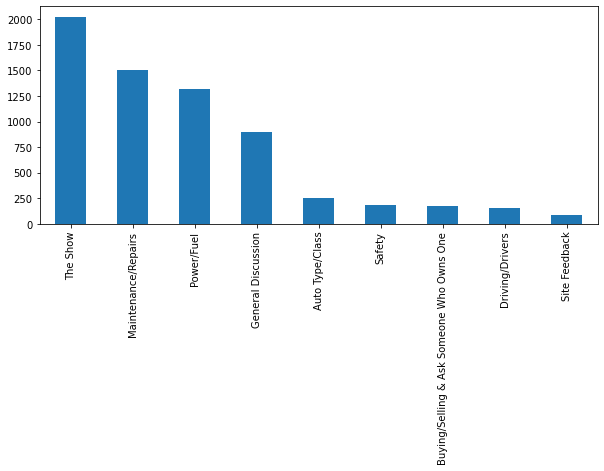

In [21]:
my_categories = ['Buying/Selling & Ask Someone Who Owns One', 'Safety',
       'Driving/Drivers', 'Site Feedback', 'Auto Type/Class',
       'Maintenance/Repairs', 'The Show', 'Power/Fuel',
       'General Discussion']
plt.figure(figsize=(10,4))
df.Category.value_counts().plot(kind='bar');

In [22]:
def print_plot(index):
    example = df[df.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
print_plot(10)

Beancounter Selling the leased car Hi,
I am not familiar with the process of getting out of a lease early. So my current car lease is $600/mo and I have paid 16 mo of it, so 20 more months remaining, which I still owe $12000 to the dealer.
Carvarna offers $50000 - 12000 (lease payoff amount) = $38000 would be the payment to me.
Kelly Blue Book Instant Cash offer is $49500 because it didn’t ask me if my car was own or lease.
Let’s say the residual value of the leased car is $32000, plus $12000 I still owe, I would have to pay the current dealer $47000 to buyout. I could accept Kelly’s offer, take the $49500, they get the car. I pay back the current dealer and make $2500.
But I don’t understand why Carvarna deducts the $12000, that they would take over the lease? All i need to do is to take their $38000 net offer, pay the current dealer the residual value of the car, and make $6000? i am so confused. Any idea?
Thank you ['You have a $12,000 lease payoff, Plus the $47,000 cash buyout = $5

Text Pre-processing

In [23]:
test_df = df.copy()
test_df['post'] = test_df['post'].astype(str)

In [24]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)# replace REPLACE_BY_SPACE_RE symbols by space in text
#     text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
test_df['post'] = test_df['post'].apply(clean_text)

In [25]:
def test_print_plot(index):
    example = test_df[test_df.index == index][['post', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
test_print_plot(10)

beancounter selling the leased car hi 
i am not familiar with the process of getting out of a lease early. so my current car lease is $600 mo and i have paid 16 mo of it  so 20 more months remaining  which i still owe $12000 to the dealer.
carvarna offers $50000 - 12000  lease payoff amount  = $38000 would be the payment to me.
kelly blue book instant cash offer is $49500 because it didn t ask me if my car was own or lease.
let s say the residual value of the leased car is $32000  plus $12000 i still owe  i would have to pay the current dealer $47000 to buyout. i could accept kelly s offer  take the $49500  they get the car. i pay back the current dealer and make $2500.
but i don t understand why carvarna deducts the $12000  that they would take over the lease? all i need to do is to take their $38000 net offer  pay the current dealer the residual value of the car  and make $6000? i am so confused. any idea?
thank you   you have a $12 000 lease payoff  plus the $47 000 cash buyout = $5

In [26]:
test_df['post'].apply(lambda x: len(x.split(' '))).sum()

4794196

In [27]:
print("lost info",4765518-4286502)

lost info 479016


Modeling the data

In [28]:
X = test_df.post
y = test_df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [29]:
X_train.head()

1806    71050 2015 volkswagen gti - warnings i am driv...
5312    shreed electrical problem on 93 probe my son s...
6154    barkydog covid 19 pick up and delivery fee we ...
2134    victor29 2020 hyundai santa fe has a really no...
592     volvo-v70 fixing a mistake on the ratings page...
Name: post, dtype: object

In [30]:
y_train.head()

1806    Maintenance/Repairs
5312             Power/Fuel
6154     General Discussion
2134    Maintenance/Repairs
592           Site Feedback
Name: Category, dtype: object

## Naive Bayes Classifier for Multinomial Models
CountVectorizer + TF-IDFTransformer + MultinomialNB

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

def Naive_Bayes_Classifier(X_train, X_test, y_train, y_test):
    nb = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                  ])
    nb.fit(X_train, y_train)

    y_pred = nb.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    
    print(classification_report(y_test, y_pred,target_names=my_categories))
    return accuracy_score(y_pred, y_test)
res1311 = Naive_Bayes_Classifier(X_train, X_test, y_train, y_test)

accuracy 0.5416666666666666
                                           precision    recall  f1-score   support

Buying/Selling & Ask Someone Who Owns One       0.00      0.00      0.00        48
                                   Safety       0.00      0.00      0.00        39
                          Driving/Drivers       0.00      0.00      0.00        36
                            Site Feedback       1.00      0.01      0.01       183
                          Auto Type/Class       0.73      0.56      0.64       286
                      Maintenance/Repairs       0.78      0.70      0.74       260
                                 The Show       0.00      0.00      0.00        50
                               Power/Fuel       0.00      0.00      0.00        18
                       General Discussion       0.43      0.93      0.59       400

                                 accuracy                           0.54      1320
                                macro avg       0.33     

/Users/jianglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Linear Support Vector Machine
CountVectorizer + TF-IDFTransformer + SGDClassifier

In [32]:
from sklearn.linear_model import SGDClassifier

def Linear_Support_Vector(X_train, X_test, y_train, y_test):
    sgd = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                   ])
    sgd.fit(X_train, y_train)

    y_pred = sgd.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred,target_names=my_categories))
    return accuracy_score(y_pred, y_test)
res1321 = Linear_Support_Vector(X_train, X_test, y_train, y_test)

accuracy 0.6765151515151515
                                           precision    recall  f1-score   support

Buying/Selling & Ask Someone Who Owns One       0.83      0.40      0.54        48
                                   Safety       0.50      0.10      0.17        39
                          Driving/Drivers       0.72      0.64      0.68        36
                            Site Feedback       0.73      0.21      0.32       183
                          Auto Type/Class       0.64      0.79      0.71       286
                      Maintenance/Repairs       0.69      0.92      0.79       260
                                 The Show       0.67      0.08      0.14        50
                               Power/Fuel       1.00      0.33      0.50        18
                       General Discussion       0.67      0.83      0.74       400

                                 accuracy                           0.68      1320
                                macro avg       0.72     

## Logistic Regression
CountVectorizer + TF-IDFTransformer + Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

def Logistic_Regression(X_train, X_test, y_train, y_test):
    logreg = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                   ])
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict (X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred,target_names=my_categories))
    return accuracy_score(y_pred, y_test)
res1331 = Logistic_Regression(X_train, X_test, y_train, y_test)

/Users/jianglu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.7772727272727272
                                           precision    recall  f1-score   support

Buying/Selling & Ask Someone Who Owns One       0.83      0.62      0.71        48
                                   Safety       0.59      0.49      0.54        39
                          Driving/Drivers       0.73      0.75      0.74        36
                            Site Feedback       0.62      0.56      0.59       183
                          Auto Type/Class       0.74      0.82      0.78       286
                      Maintenance/Repairs       0.82      0.88      0.85       260
                                 The Show       0.74      0.50      0.60        50
                               Power/Fuel       0.85      0.61      0.71        18
                       General Discussion       0.86      0.87      0.86       400

                                 accuracy                           0.78      1320
                                macro avg       0.75     

Decision Tree
CountVectorizer + TF-IDFTransformer + DecisionTreeClassifier

## Decision Tree
CountVectorizer + TF-IDFTransformer + DecisionTreeClassifier

In [34]:
from sklearn.tree import DecisionTreeClassifier

def Decision_Tree(X_train, X_test, y_train, y_test):
    dtree = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', DecisionTreeClassifier(random_state=0)),
                   ])
    dtree.fit(X_train, y_train)

    y_pred = dtree.predict (X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred,target_names=my_categories))
    return accuracy_score(y_pred, y_test)
res1341 = Decision_Tree(X_train, X_test, y_train, y_test)

accuracy 0.6545454545454545
                                           precision    recall  f1-score   support

Buying/Selling & Ask Someone Who Owns One       0.51      0.65      0.57        48
                                   Safety       0.44      0.31      0.36        39
                          Driving/Drivers       0.65      0.72      0.68        36
                            Site Feedback       0.46      0.44      0.45       183
                          Auto Type/Class       0.63      0.60      0.62       286
                      Maintenance/Repairs       0.81      0.84      0.82       260
                                 The Show       0.49      0.36      0.41        50
                               Power/Fuel       0.11      0.11      0.11        18
                       General Discussion       0.73      0.76      0.74       400

                                 accuracy                           0.65      1320
                                macro avg       0.54     

## Results
Results of the previously trained models

In [35]:
import pandas as pd

results = pd.DataFrame({'Model': ['Naive Bayes MultinomialNB', 'Linear SVM', 'Logistic Regression', 'Decision Tree'],
                         'Accuracy': [res1311, res1321, res1331, res1341]})
results.set_index('Model')
results.sort_values(by='Accuracy')

,Model,Accuracy
0,Naive Bayes MultinomialNB,0.541667
3,Decision Tree,0.654545
1,Linear SVM,0.676515
2,Logistic Regression,0.777273


Cross Validation with linear SVM

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def Mean_cv_res_sgd(X_train,y_train):
    sgd = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                   ])
    cv_res_sgd = cross_val_score(sgd, X_train, y_train, cv=10)
    mean_cv_res_sgd = np.mean(cv_res_sgd)
    return (mean_cv_res_sgd)
mean_cv_res_sgd = Mean_cv_res_sgd(X_train,y_train)

In [37]:
print(mean_cv_res_sgd)

0.6825757575757576


## Strategy 2
Remove stop words (+ what was done in Strategy 1)

In [38]:
# test_df2 = test_df.copy()

In [39]:
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

# def clean_text(text):
#     """
#         text: a string
        
#         return: modified initial string
#     """
#     text = BeautifulSoup(text, "lxml").text # HTML decoding
#     text = text.lower() # lowercase text
#     text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
#     #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
#     #text = ''.join(word for word in text if word not in punct)  # remove punctuation
#     text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
#     return text
    
# test_df2['post'] = test_df2['post'].apply(clean_text)

In [40]:
# def test_print_plot(index):
#     example = test_df2[test_df2.index == index][['post', 'Category']].values[0]
#     if len(example) > 0:
#         print(example[0])
#         print('Category:', example[1])
# test_print_plot(10)

## Modeling the data

In [41]:
# X = test_df2.post
# y = test_df2.Category
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Naive Bayes Classifier for Multinomial Models
CountVectorizer + TF-IDFTransformer + MultinomialNB

In [42]:
# res2311 = Naive_Bayes_Classifier(X_train, X_test, y_train, y_test)

## Linear Support Vector Machine
CountVectorizer + TF-IDFTransformer + SGDClassifier

In [43]:
# res2321 = Linear_Support_Vector(X_train, X_test, y_train, y_test)

## Logistic Regression
CountVectorizer + TF-IDFTransformer + Logistic Regression

In [44]:
# res2331 = Logistic_Regression(X_train, X_test, y_train, y_test)

## Decision Tree
CountVectorizer + TF-IDFTransformer + DecisionTreeClassifier

In [45]:
# res2341 = Decision_Tree(X_train, X_test, y_train, y_test)

In [46]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# conf_mat = confusion_matrix(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat, annot=True, fmt='d',
#             xticklabels=my_categories, yticklabels=my_categories)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

## Results
Results of the previously trained models

In [47]:
# import pandas as pd

# results = pd.DataFrame({'Model': ['Naive Bayes MultinomialNB', 'Linear SVM', 'Logistic Regression', 'Decision Tree'],
#                          'Accuracy': [res2311, res2321, res2331, res2341]})
# results.set_index('Model')
# results.sort_values(by='Accuracy')

### Cross Validation with linear SVM

In [48]:
# mean_cv_res_sgd2 = Mean_cv_res_sgd(X_train, y_train)
# print(mean_cv_res_sgd2)

## Strategy 3
text.replace(r'\n', ' ') + Strategy 2

In [49]:
# test_df3 = test_df2.copy()

In [50]:
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\'\“\”\’\|@,;]')
# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

# def clean_text(text):
#     """
#         text: a string
        
#         return: modified initial string
#     """
#     text = BeautifulSoup(text, "lxml").text # HTML decoding
#     text = text.lower() # lowercase text
#     text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
#     text = text.replace(r'\n', ' ')
#     #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
#     #text = ''.join(word for word in text if word not in punct)  # remove punctuation
#     text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
#     return text
    
# test_df3['post'] = test_df3['post'].apply(clean_text)

In [51]:
# def test_print_plot(index):
#     example = test_df3[test_df3.index == index][['post', 'Category']].values[0]
#     if len(example) > 0:
#         print(example[0])
#         print('Category:', example[1])
# test_print_plot(10)

In [52]:
# res3311 = Naive_Bayes_Classifier(X_train, X_test, y_train, y_test)

In [53]:
# res3321 = Linear_Support_Vector(X_train, X_test, y_train, y_test)

In [54]:
# res3331 = Logistic_Regression(X_train, X_test, y_train, y_test)

In [55]:
# res3341 = Decision_Tree(X_train, X_test, y_train, y_test)

In [56]:
# import pandas as pd

# results = pd.DataFrame({'Model': ['Naive Bayes MultinomialNB', 'Linear SVM', 'Logistic Regression', 'Decision Tree'],
#                          'Accuracy': [res3311, res3321, res3331, res3341]})
# results.set_index('Model')
# results.sort_values(by='Accuracy')

## Cross Validation with linear SVM

In [57]:
# X = test_df3.post
# y = test_df3.Category
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [58]:
# mean_cv_res_sgd3 = Mean_cv_res_sgd(X_train, y_train)
# print(mean_cv_res_sgd3)

## Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def Mean_cv_res_rf(X_train, y_train,m,n):
    rf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', RandomForestClassifier(n_estimators=n, max_depth=m, random_state=0)),
                   ])

    cv_res_rf = cross_val_score(rf, X_train, y_train, cv=10)
    mean_cv_res_rf = np.mean(cv_res_rf)
    return mean_cv_res_rf

In [60]:
# print(Mean_cv_res_rf(X_train, y_train,10,300))

In [61]:
# print(Mean_cv_res_rf(X_train, y_train,100,300))

In [62]:
# print(Mean_cv_res_rf(X_train, y_train,500,300))

In [63]:
# print(Mean_cv_res_rf(X_train, y_train,500,400))

In [64]:
# print(Mean_cv_res_rf(X_train, y_train,1000,400))

In [65]:
# print(Mean_cv_res_rf(X_train, y_train,500,500))

In [66]:
def Mean_cv_res_tfidf(X_train, y_train,m,n):
    rf = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=n, max_depth=m, random_state=0)),
               ])

    cv_res_rf_tfidf = cross_val_score(rf, X_train, y_train, cv=10)
    mean_cv_res_rf_tfidf = np.mean(cv_res_rf_tfidf)
    return mean_cv_res_rf_tfidf

In [ ]:
print(Mean_cv_res_tfidf(X_train, y_train,500,500))

In [ ]:
# print(Mean_cv_res_tfidf(X_train, y_train,200,100))

Using TF-IDF as a vectorizer and transformer is slighly better than using CountVectorizer as a Vectorizer.

In [ ]:
def Mean_cv_res_sgd_tfidf(X_train, y_train, max_iter):
    sgd = Pipeline([('vect', TfidfVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=max_iter, tol=None)),
                   ])
    cv_res_sgd_tfidf = cross_val_score(sgd, X_train, y_train, cv=10)
    mean_cv_res_sgd_tfidf = np.mean(cv_res_sgd_tfidf)
    return mean_cv_res_sgd_tfidf


In [ ]:
mean_cv_res_sgd_tfidf = Mean_cv_res_sgd_tfidf(X_train, y_train, 10)

In [ ]:
mean_cv_res_sgd_tfidf = Mean_cv_res_sgd_tfidf(X_train, y_train, 100)

## XGBoost

In [ ]:
import sys
!{sys.executable} -m pip install xgboost

In [ ]:
import xgboost as xgb

xgb = Pipeline(steps=[('vect', TfidfVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])

cv_res_xgb_tfidf = cross_val_score(xgb, X_train, y_train, cv=10)
mean_cv_res_xgb_tfidf = np.mean(cv_res_xgb_tfidf)

In [ ]:
mean_cv_res_xgb_tfidf

In [ ]:
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
res_xgb = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred,target_names=my_categories))

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=my_categories, yticklabels=my_categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Light GBM

In [ ]:
import sys
!{sys.executable} -m pip install lightgbm

In [ ]:
import lightgbm as lgbm

tfidf_vec = TfidfVectorizer(dtype=np.float32, sublinear_tf=True, use_idf=True, smooth_idf=True)
X_data_tfidf = tfidf_vec.fit_transform(test_df3['post'])
X_train_tfidf = tfidf_vec.transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

clf_LGBM = lgbm.LGBMClassifier(objective='multiclass', verbose=-1, learning_rate=0.5, max_depth=20, num_leaves=50, n_estimators=120, max_bin=2000,)
clf_LGBM.fit(X_train_tfidf, y_train, verbose=-1)
predicted_LGBM = clf_LGBM.predict(X_test_tfidf)

In [ ]:
cv_res_lgbm_tfidf = cross_val_score(clf_LGBM, X_train_tfidf, y_train, cv=10)
mean_cv_res_lgbm_tfidf = np.mean(cv_res_lgbm_tfidf)

In [ ]:
mean_cv_res_lgbm_tfidf

In [ ]:
print('accuracy %s' % accuracy_score(predicted_LGBM, y_test))
res_lgbm = accuracy_score(predicted_LGBM, y_test)
print(classification_report(y_test, predicted_LGBM,target_names=my_categories))

## Other: Investigating Abbreviations

In [ ]:
data = pd.read_csv('combined_csv.csv')

In [ ]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDSv2 = [word.upper() for word in STOPWORDS]

In [ ]:
STOPWORDSv2

In [ ]:
def clean_data(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(str(text), "lxml").text # HTML decoding
    text = ' '.join(word for word in str(text).split() if word not in STOPWORDSv2) # delete stopwors from text
    return text
    
data['Leading Comment'] = data['Leading Comment'].apply(clean_data)

In [ ]:
data['Leading Comment'].head()

In [ ]:
upcase_words = {}
regex = r"([A-Z]{3})"

for i, row in zip(range(500), data['Leading Comment'][:500]):
    row = data['Leading Comment'].str.findall(regex)[i]
    if len(row) != 0:
        upcase_words[i] = row

In [ ]:
df_upword = pd.DataFrame(upcase_words.items(), columns=['Original Index', 'Upper Case Words'])

In [ ]:
df_upword.head()

In [ ]:
df_upword['Number of UpCase Words'] =  df_upword['Upper Case Words'].apply(lambda x: len(x))

In [ ]:
df_upword.head()

In [ ]:
df_upword['Number of UpCase Words'].values.max()

In [ ]:
df_upword['Number of UpCase Words'][df_upword['Number of UpCase Words'].values == 16]

In [ ]:
df_upword['Number of UpCase Words'][0]

In [ ]:
df_upword['Number of UpCase Words'][29]

In [ ]:
df_upword['Upper Case Words'][0]

In [ ]:
df_upword['Upper Case Words'][29]

In [ ]:
def ABB(n):
    abb = {}
    for word in df_upword['Upper Case Words'][0]:
        if word in abb.keys():
            abb[word] += 1
        else:
            abb[word] = 1
    return abb

In [ ]:
ABB(0)

In [ ]:
ABB(29)